In [ ]:
# Name: Rohith Ganesan
# Student ID: 20553375


# Dataset: Hate Speech and Offensive English Language on Twitter
# Machine Learning Models Implemented - SVM, Logestic Regression, K-Nearest Neighbous , Random Forest, Multilayer Perceptron.
# Deep Learning Models Implements - RNN, Bi-LSTM, BERT.
# Data Augmented for Deep learning Models under (33%, 50%, 75%) of the training Data.

# Importing

In [ ]:
# Importing the Required Packages

import numpy as np
import pandas as pd
import os
from pathlib import Path

# NLTK Packages for NLP Tasks
import string
import nltk
from nltk.corpus import stopwords

# Scikitlearn functions imported for doing evaluation of model and also analyse the dataset
import scipy.io
import scipy.linalg
from scipy.sparse import csr_matrix, vstack, lil_matrix
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Loading the ML Models used to classify the data into hate, offensive and neither category
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Packages for visualization
import plotly.express as px
import plotly.figure_factory as ff


In [ ]:
# Downloading the necessary packages from NLTK library
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Function to load the dataset and return the Data frame
def load_data(path):
    df = pd.read_csv(path, index_col=0)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [ ]:
# We load the data and print the 1st 10 entries from the Dataframe.
path = r"/content/drive/MyDrive/Disseration UON/Datasets/labeled_data.csv"
tdf = load_data(path)
tdf.head(10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,3,0,1,RT @Rob_San9993: @214bighappy that bitch was l...
1,4,1,3,0,1,RT @Carxlito: &#8220;@tropicaldrew_: @TonyGets...
2,3,0,3,0,1,In class still drunk from last night and this ...
3,3,1,2,0,1,"RT @E_Tae627: ""@KB_Three: Lil skinny bitch thr..."
4,3,0,0,3,2,RT @BaddieBellaDona: Instant mashed potatoes a...
5,3,1,2,0,1,"&#8220;@Vabtwin8211: @Vivalaquintaa agreed, ea..."
6,3,0,3,0,1,They had a steak category. \n\nRan that bitch ...
7,3,0,3,0,1,"&#8220;@IIiirb: Bouta let Banko kno, I'm goin ..."
8,3,1,2,0,1,@MeekMill u really got these coons out here dr...
9,3,3,0,0,0,Black bitches don't be kickin up in our school...


In [ ]:


# Remove stop words, special chars
# stem the word tokens
# re.sub(r'^https?:\/\/.*[\r\n]*', '', text)

# The function is used to clean the tweet, i.e, to remove the special characters and the stop words.
def Tweet_Cleaning(sent):
    stemmer = nltk.PorterStemmer()
    tknzr = nltk.RegexpTokenizer(r'[a-zA-Z0-9]+')

    exclp = list(string.punctuation)
    exclc = [
        "'re", "n't", "'m", "'s", "n't", "'s",
        "``", "''", "'ve", "'m", "'ll", "'ve",
        "...", "http", "https"]
    sw = set(stopwords.words("english") + exclp + exclc)

    tokens = tknzr.tokenize(sent.lower())
    words = [stemmer.stem(token) for token in tokens if not token in sw]
    return " ".join(words)

In [ ]:
# Function to clean the tweet and update the dataframe with the cleaned version of the tweet
def Tweet_Cleaning_DF(df):
    df["tweet"] = df["tweet"].apply(lambda t: Tweet_Cleaning(t))
    return df

In [ ]:
# Printing the data frame after doing the tweet-cleaning
tdf = Tweet_Cleaning_DF(tdf)
tdf.head(10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,3,0,1,rt davi lyndsi lol block littl bitch day 12852...
1,6,0,6,0,1,hoe deserv kick vagina lucki aint tryna loos shoe
2,3,0,2,1,1,text ya bitch like ya man suck meet da birkin ...
3,3,2,1,0,0,lie ass hoe lol
4,3,0,3,0,1,skimp shit bitch
5,3,0,3,0,1,rt swizzzi know hoe believ astrolog ima make sign
6,3,2,1,0,0,dem nigga ca white hoe love beauti black sista
7,3,0,2,1,1,rt coley cee lil aerii yeaaaaahhhh like relati...
8,3,0,0,3,2,cuz trash bash say need go back jail
9,6,1,5,0,1,rt adddisonn smoke good weed bad bitch


In [ ]:
# Function used to mathematically explain the entire dataset. The parameters such as total entries, the mean, standard deviation, minimum and max-values are put up
def Data_Summary(df):

    content = df["tweet"].values
    word_tok = [word.lower() for item in content for word in nltk.word_tokenize(item)]
    st_words = set(word_tok)

    fact = {
        "TotalCount": len(content),
        "TotalWords": len(word_tok),
        "TotalUniqueWords": len(st_words),
        "MeanWordsPerTweet": len(word_tok) / len(content),
    }

    return fact, df.describe()

In [ ]:
f, s = Data_Summary(tdf)
s

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [ ]:
# Mean words per tweet, total number of sentences, total words count and unique words count
f

{'TotalCount': 24783,
 'TotalWords': 239126,
 'TotalUniqueWords': 31134,
 'MeanWordsPerTweet': 9.648791510309486}

In [ ]:
# Function used to plot bar graph corresponding to word v/s its frequency of occurence in the entire dataset
def Show_Freq_Plot(df, label, labelDescr = ""):
    xdf = df[df["class"] == label]
    content = xdf["tweet"].values
    word_tok = [word.lower() for item in content for word in nltk.word_tokenize(item)]
    st_words = set(word_tok)
    freq_dist = nltk.FreqDist(word_tok)
    ls_freq = [(word, frequency) for word, frequency in freq_dist.most_common(20)]
    twdf = pd.DataFrame(ls_freq, columns=["Word", "Frequency"])
    tfig = px.bar(twdf, x="Word", y="Frequency", title="Top 20 most frequent words - " + labelDescr)
    tfig.show()

In [ ]:
# For class label - 0, i.e, Hate Speech. The top 20 frequently used words are plotted
Show_Freq_Plot(tdf, 0, "hate speech")

In [ ]:
# For class label - 1, i.e, Offensive Speech. The top 20 frequently used words are plotted
Show_Freq_Plot(tdf, 1, "offensive")

In [ ]:
# For class label - 2, i.e, Neither Hate nor Offensive Speech. The top 20 frequently used words are plotted
Show_Freq_Plot(tdf, 2, "neither")

In [ ]:
pip install yellowbrick


In [ ]:
from yellowbrick.text import TSNEVisualizer


In [ ]:
'''
The TSNEVisualizer creates an inner transformer pipeline that applies such a decomposition first (SVD with 50 components by default), then performs the t-SNE embedding.
The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required.
'''
def Show_TSNE_Plot(df):
    tknzr = nltk.RegexpTokenizer(r'[a-zA-Z0-9]+')
    sents = df["tweet"].values
    labels = np.array(df["class"].values)
    vcrz = TfidfVectorizer(lowercase=True,stop_words='english',
                        analyzer="word",
                        max_features=5000,
                        tokenizer = tknzr.tokenize)
    sents_vals = vcrz.fit_transform(sents)
    tsne = TSNEVisualizer(labels=[0,1,2])
    tsne.fit(sents_vals, labels)
    tsne.show()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/yellowbrick/text/tsne.py:401: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



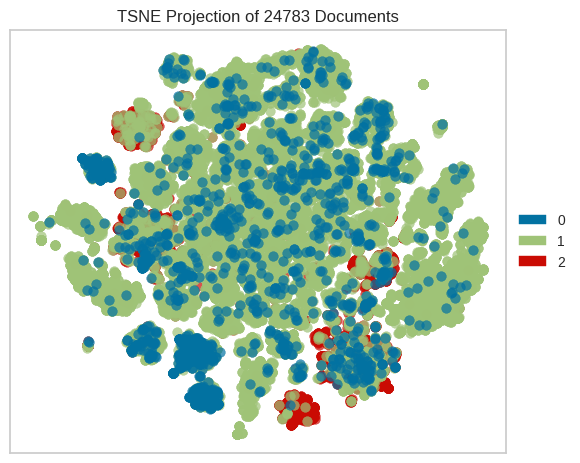

In [ ]:
# Obtaining the TSNE plot
Show_TSNE_Plot(tdf)

In [ ]:
# TF-IDF scores get computed with the help of TFIDF Vectorizer.
def Model_TF_IDF(df, fset=["c", "w"], max_feats=5000, ngram_range = (1,3)):
    tknzr = nltk.RegexpTokenizer(r'[a-zA-Z0-9]+')
    sents = df["tweet"].values
    labels = np.array(df["class"].values)
    features = []

    if "w" in fset:
        wvcrz = TfidfVectorizer(lowercase=True,stop_words='english',
                            ngram_range = ngram_range,
                            analyzer="word",
                            max_features=max_feats,
                            tokenizer = tknzr.tokenize)
        features.append(('wvect_features', Pipeline([("wvect", wvcrz)])))

    if "c" in fset:
        cvcrz = TfidfVectorizer(lowercase=True,stop_words='english',
                            ngram_range = ngram_range,
                            analyzer="char",
                            max_features=max_feats,
                            tokenizer = tknzr.tokenize)
        features.append(('cvect_features', Pipeline([("cvect", cvcrz)])))

    merger = FeatureUnion(features)
    sents_vals = merger.fit_transform(sents)
    sents_vals_lil = lil_matrix(sents_vals)

    return sents_vals_lil, labels

In [ ]:
# Bar Graph plots to depict the number of sentences pertaining to Hate, Offensive and Neither categories
def Similarity_Plot(df):

    lil_mat, labels = Model_TF_IDF(df, fset=["w"])
    hate_vals = lil_mat[labels == 0,:]
    off_vals = lil_mat[labels == 1,:]
    neit_vals = lil_mat[labels == 2,:]

    sim_matrices = [
        ("Hate", 'In Class', cosine_similarity(hate_vals, hate_vals)),
        ("Offensive", 'In Class', cosine_similarity(off_vals, off_vals)),
        ("Neither",'In Class', cosine_similarity(neit_vals, neit_vals)),
        ("Hate v Offensive",'Other Class', cosine_similarity(hate_vals, off_vals)),
        ("Offensive v Neither",'Other Class', cosine_similarity(off_vals, neit_vals)),
        ("Neither v Hate",'Other Class', cosine_similarity(hate_vals, neit_vals)),
    ]

    scores = []

    for lab, group, score_matrix in sim_matrices:
        sdf = pd.DataFrame(score_matrix)
        sdf.replace(0, np.nan, inplace=True)
        sdf.replace(1, np.nan, inplace=True)
        sdf["max"] = sdf.max(axis=1)
        score = sdf["max"].mean()
        scores.append((lab, group, score))

    simdf = pd.DataFrame(scores, columns=["Label", "Grouping", "Score"])
    tfig = px.bar(simdf[simdf["Grouping"] == "In Class"], x="Label", y="Score", color="Label", title="In class similarities")
    tfig.show()

    tfig = px.bar(simdf[simdf["Grouping"] == "Other Class"], x="Label", y="Score", color="Label", title="Out of class similarities")
    tfig.show()

In [ ]:
# In-class and Out-of-class similarities plot is obtained
Similarity_Plot(tdf)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [ ]:
# Train-Test-Split of the dataset is done here. The dataset is undergoing TFIDF Vectorization followed by splitting of the values.
def Train_Test_Data(df, fset=["c", "w"], tsize=0.25):

    x_values, y_values = Model_TF_IDF(df, fset=fset, max_feats=10000, ngram_range = (1,3))

    sel_mod = SelectFromModel(
        LogisticRegression(penalty='l2', solver='saga', multi_class='multinomial', random_state=1),
        threshold=-np.inf)
    sel_feats = sel_mod.fit_transform(x_values, y_values)

    x_train, x_test, y_train, y_test = train_test_split(
        sel_feats, y_values, test_size=tsize, random_state=1, stratify=y_values
    )
    return x_train, x_test, y_train, y_test

# Machine Learning Models

In [ ]:
# Function for Logistic Regression Model
def run_logreg(df):
    x_train, x_test, y_train, y_test = Train_Test_Data(df)

    clf = LogisticRegression(penalty=None, random_state=0, solver='saga')
    clf.fit(x_train, y_train)
    predicted = clf.predict(x_test)
    return clf, predicted, y_test

# Function for Linear SVM Model
def run_linsvm(df):
    x_train, x_test, y_train, y_test = Train_Test_Data(df)

    clf = LinearSVC()
    clf.fit(x_train, y_train)
    predicted = clf.predict(x_test)
    return clf, predicted, y_test

# Function for Multilayer Perceptron Model
def run_mlptron(df):
    x_train, x_test, y_train, y_test = Train_Test_Data(df)

    clf = MLPClassifier()
    clf.fit(x_train, y_train)
    predicted = clf.predict(x_test)
    return clf, predicted, y_test

# Function for Random Forest Model
def run_rand_forest(df):
  x_train, x_test, y_train, y_test = Train_Test_Data(df)

  clf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
  clf.fit(x_train, y_train)
  predicted = clf.predict(x_test)
  return clf, predicted, y_test

# Function for KNN Model
def run_KNN(df):
  x_train, x_test, y_train, y_test = Train_Test_Data(df)

  clf = KNeighborsClassifier()
  clf.fit(x_train, y_train)
  predicted = clf.predict(x_test)
  return clf, predicted, y_test

In [ ]:
# Function used to obtain the evaluation metrics -> Confusion Matrix, Class wise report for precision, recall and F1-score
def show_results(predicted, y_test, labels=[0,1,2],  label_descr=["Hate", "Offensive", "Neither"]):
    clsr = classification_report(y_test, predicted, target_names=labels, output_dict=True)
    cm = confusion_matrix(y_test, predicted, labels=labels)

    cr_df = pd.DataFrame(clsr).transpose()
    print(cr_df)

    fig = ff.create_annotated_heatmap(cm, x=label_descr, y=label_descr)
    fig.update_layout(title_text='Confusion Matrix')
    fig.show()

In [ ]:
# Testing for KNN
clf, pred, y_test = run_KNN(tdf)
show_results(pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



              precision    recall  f1-score      support
0              0.496933  0.226891  0.311538   357.000000
1              0.892530  0.874114  0.883226  4798.000000
2              0.546477  0.700288  0.613895  1041.000000
accuracy       0.807618  0.807618  0.807618     0.807618
macro avg      0.645313  0.600431  0.602886  6196.000000
weighted avg   0.811596  0.807618  0.805036  6196.000000


In [ ]:
# Testing for Logistic Regression
clf, pred, y_test = run_logreg(tdf)
show_results(pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



              precision    recall  f1-score      support
0              0.413934  0.282913  0.336106   357.000000
1              0.922065  0.949354  0.935510  4798.000000
2              0.857708  0.833814  0.845592  1041.000000
accuracy       0.891543  0.891543  0.891543     0.891543
macro avg      0.731236  0.688694  0.705736  6196.000000
weighted avg   0.881975  0.891543  0.885867  6196.000000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [ ]:
# Testing for Linear SVM
clf, pred, y_test = run_linsvm(tdf)
show_results(pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



              precision    recall  f1-score      support
0              0.507692  0.277311  0.358696   357.000000
1              0.922365  0.955815  0.938792  4798.000000
2              0.843537  0.833814  0.838647  1041.000000
accuracy       0.896223  0.896223  0.896223     0.896223
macro avg      0.757865  0.688980  0.712045  6196.000000
weighted avg   0.885229  0.896223  0.888543  6196.000000


In [ ]:
# Testing for Multilayer-Perceptron
clf, pred, y_test = run_mlptron(tdf)
show_results(pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



              precision    recall  f1-score      support
0              0.418605  0.252101  0.314685   357.000000
1              0.917404  0.951438  0.934111  4798.000000
2              0.847761  0.818444  0.832845  1041.000000
accuracy       0.888799  0.888799  0.888799     0.888799
macro avg      0.727923  0.673994  0.693880  6196.000000
weighted avg   0.876963  0.888799  0.881407  6196.000000


In [ ]:
# Testing for Random Forest Classifier
clf, pred, y_test = run_rand_forest(tdf)
show_results(pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



              precision    recall  f1-score      support
0              0.608108  0.126050  0.208817   357.000000
1              0.865196  0.972489  0.915710  4798.000000
2              0.806584  0.564841  0.664407  1041.000000
accuracy       0.855229  0.855229  0.855229     0.855229
macro avg      0.759963  0.554460  0.596311  6196.000000
weighted avg   0.840535  0.855229  0.832758  6196.000000


In [ ]:
tdf

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,1,2,2,ofhdirector everybodi look bird kill wind mill...
1,3,0,3,0,1,rt dayannaa bobbi bitch bobbi bitch 128293 128...
2,3,0,3,0,1,rt superrrrmcnasti lmfao bitch give head back ...
3,3,0,1,2,2,gung ho
4,3,0,1,2,2,pictur angu run side fob sharana everi day afg...
...,...,...,...,...,...,...
24778,3,1,2,0,1,rt wavykirk courtaintshit yeah yo girlfriend b...
24779,3,0,3,0,1,starrhal rene gadecowboy absolut speechless bi...
24780,3,1,2,0,1,rt tylerssooclutch dad hoe fuck 127797
24781,3,0,0,3,2,philosophi existenti depth trash pop mtvhottes...


# RNN & Bi-LSTM

In [ ]:
# Function for RNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def run_rnn(x_train, x_test, y_train, y_test):
    # Convert to dense array if sparse
    if hasattr(x_train, "toarray"):
        x_train = x_train.toarray()
        x_test = x_test.toarray()

    # Reshape x_train and x_test to fit RNN input requirements (samples, timesteps, features)
    x_train_rnn = np.expand_dims(x_train, axis=2)
    x_test_rnn = np.expand_dims(x_test, axis=2)

    # Define the RNN model
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=(x_train_rnn.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification example
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(x_train_rnn, y_train, epochs=10, batch_size=16, validation_data=(x_test_rnn, y_test))

    # Predict
    predicted = model.predict(x_test_rnn)
    predicted_classes = (predicted > 0.5).astype(int)  # Convert probabilities to binary classes

    return model, predicted_classes, y_test

# Function for BiLSTM Model
def run_bilstm(x_train, x_test, y_train, y_test):
    # Convert to dense array
    if hasattr(x_train, "toarray"):
        x_train = x_train.toarray()
        x_test = x_test.toarray()

    # Reshape x_train and x_test to fit LSTM input requirements (samples, timesteps, features)
    x_train_lstm = np.expand_dims(x_train, axis=2)
    x_test_lstm = np.expand_dims(x_test, axis=2)

    # Define the BiLSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(64, input_shape=(x_train_lstm.shape[1], 1))))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification example
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(x_train_lstm, y_train, epochs=10, batch_size=16, validation_data=(x_test_lstm, y_test))

    # Predict
    predicted = model.predict(x_test_lstm)
    predicted_classes = (predicted > 0.5).astype(int)  # Convert probabilities to binary classes

    return model, predicted_classes, y_test


In [ ]:

x_train, x_test, y_train, y_test = Train_Test_Data(tdf)

# Run RNN model

print("RNN")

rnn_model, rnn_predictions, rnn_true_labels = run_rnn(x_train, x_test, y_train, y_test)

show_results(rnn_predictions, rnn_true_labels)
# Run BiLSTM model


print("BiSLTM")
bilstm_model, bilstm_predictions, bilstm_true_labels = run_bilstm(x_train, x_test, y_train, y_test)
show_results(bilstm_predictions, bilstm_true_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2865s 2s/step - accuracy: 0.7763 - loss: -1.9183 - val_accuracy: 0.7744 - val_loss: -6.7524
Epoch 2/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2847s 2s/step - accuracy: 0.7702 - loss: -8.3481 - val_accuracy: 0.7744 - val_loss: -12.4599
Epoch 3/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2846s 2s/step - accuracy: 0.7768 - loss: -13.5306 - val_accuracy: 0.7744 - val_loss: -18.1555
Epoch 4/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2849s 2s/step - accuracy: 0.7765 - loss: -19.1644 - val_accuracy: 0.7744 - val_loss: -23.8982
Epoch 5/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2850s 2s/step - accuracy: 0.7795 - loss: -24.5760 - val_accuracy: 0.7744 - val_loss: -29.6021
Epoch 6/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2850s 2s/step - accuracy: 0.7763 - loss: -29.9483 - val_accuracy: 0.7744 - val_loss: -35.3669
Epoch 7/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2848s 2s/step - accuracy: 0.7762 - loss: -36.4380 - val_accuracy: 0.7744 - val_loss: -41.1424
Epoch 8/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 2851s 2s/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



BiSLTM


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1221s 1s/step - accuracy: 0.7696 - loss: -4.3762 - val_accuracy: 0.7744 - val_loss: -13.5781
Epoch 2/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1217s 1s/step - accuracy: 0.7731 - loss: -17.3232 - val_accuracy: 0.7744 - val_loss: -24.9604
Epoch 3/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - accuracy: 0.7763 - loss: -26.8906 - val_accuracy: 0.7744 - val_loss: -36.4317
Epoch 4/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - accuracy: 0.7743 - loss: -38.9653 - val_accuracy: 0.7744 - val_loss: -47.9367
Epoch 5/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - accuracy: 0.7752 - loss: -50.5428 - val_accuracy: 0.7744 - val_loss: -59.3977
Epoch 6/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - accuracy: 0.7744 - loss: -65.4941 - val_accuracy: 0.7744 - val_loss: -70.9301
Epoch 7/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - accuracy: 0.7726 - loss: -71.0127 - val_accuracy: 0.7744 - val_loss: -82.4769
Epoch 8/10
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 1217s 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# BERT

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the tokenizer and BERT model (for feature extraction)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Preparing the dataset
texts = tdf['tweet'].values
labels = tdf['class'].values

# Tokenize the texts
max_len = 128
tokenized_data = tokenizer(
    texts.tolist(),
    max_length=max_len,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Convert tokenized data and labels into NumPy arrays
input_ids_np = tokenized_data['input_ids'].numpy()
attention_masks_np = tokenized_data['attention_mask'].numpy()
labels_np = labels

# Split dataset into training and validation sets
train_input_ids, val_input_ids, train_labels, val_labels = train_test_split(input_ids_np, labels_np, test_size=0.2, random_state=42)
train_attention_masks, val_attention_masks = train_test_split(attention_masks_np, test_size=0.2, random_state=42)

# Convert the split datasets back to TensorFlow tensors
train_input_ids = tf.convert_to_tensor(train_input_ids)
val_input_ids = tf.convert_to_tensor(val_input_ids)
train_attention_masks = tf.convert_to_tensor(train_attention_masks)
val_attention_masks = tf.convert_to_tensor(val_attention_masks)
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)

# Prepare the dataset for TensorFlow
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_input_ids, 'attention_mask': train_attention_masks}, train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_input_ids, 'attention_mask': val_attention_masks}, val_labels)).batch(batch_size)

# Build a Sequential-like model using BERT for feature extraction
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

# Using a Lambda layer to wrap the BERT model and ensure the correct tensor types, specifying the output shape
def bert_layer(x):
    return bert_model(x[0], attention_mask=x[1]).last_hidden_state

bert_outputs = tf.keras.layers.Lambda(bert_layer, output_shape=(max_len, 768))([input_ids, attention_mask])

# Using the [CLS] token output for classification
cls_output = bert_outputs[:, 0, :]  # CLS token's output

# Adding a dense layer for classification
x = tf.keras.layers.Dense(128, activation='relu')(cls_output)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Defining the final model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compiling the model using the RMSprop optimizer and binary crossentropy loss
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
epochs = 10
model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

# Evaluating the model
predictions = model.predict(val_dataset)
predicted_classes = tf.cast(tf.round(predictions), tf.int32)

# Calculating metrics
accuracy = accuracy_score(val_labels, predicted_classes)
precision = precision_score(val_labels, predicted_classes, average='weighted')
recall = recall_score(val_labels, predicted_classes, average='weighted')
f1 = f1_score(val_labels, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.7755 - loss: -0.9906 - val_accuracy: 0.7767 - val_loss: -3.3889
Epoch 2/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7778 - loss: -5.1064 - val_accuracy: 0.7767 - val_loss: -7.6250
Epoch 3/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7778 - loss: -10.2158 - val_accuracy: 0.7767 - val_loss: -12.7331
Epoch 4/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7778 - loss: -16.3693 - val_accuracy: 0.7767 - val_loss: -18.7014
Epoch 5/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7778 - loss: -23.5258 - val_accuracy: 0.7767 - val_loss: -25.5273
Epoch 6/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7778 - loss: -31.6647 - val_accuracy: 0.7767 - val_loss: -33.2188
Epoch 7/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7778 - loss: -40.7577 - val_accuracy: 0.7767 - val_loss: -41.7725
Epoch 8/10
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#Data Augmentation

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to show the results
def show_results(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    return accuracy, precision, recall, f1

# Function for RNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional, LSTM



# Main loop for different dataset sizes
data_sizes = [0.33, 0.5, 0.75]  # 33%, 50% and 75% of the Train Data



for data_size in data_sizes:
    print(f"\nRunning models for {int(data_size * 100)}% of the data...")

    path = r"/content/drive/MyDrive/Disseration UON/Datasets/labeled_data.csv"
    tdf = load_data(path)
    tdf = tdf.sample(frac=data_size).reset_index(drop=True)
    tdf = Tweet_Cleaning_DF(tdf)
    x_train, x_test, y_train, y_test = Train_Test_Data(tdf)
    len(y_train)


    # Run RNN model
    print("RNN")
    rnn_model, rnn_predictions, rnn_true_labels = run_rnn(x_train, x_test, y_train, y_test)
    show_results(rnn_predictions, rnn_true_labels)
    # Run BiLSTM model


    print("BiSLTM")
    bilstm_model, bilstm_predictions, bilstm_true_labels = run_bilstm(x_train, x_test, y_train, y_test)
    show_results(bilstm_predictions, bilstm_true_labels)


    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    # Preparing dataset
    texts = tdf['tweet'].values
    labels = tdf['class'].values

    # Tokenize the texts
    max_len = 128
    tokenized_data = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # Converting tokenized data and labels into NumPy arrays
    input_ids_np = tokenized_data['input_ids'].numpy()
    attention_masks_np = tokenized_data['attention_mask'].numpy()
    labels_np = labels

    # Spliting dataset into training and validation sets
    train_input_ids, val_input_ids, train_labels, val_labels = train_test_split(input_ids_np, labels_np, test_size=0.2, random_state=42)
    train_attention_masks, val_attention_masks = train_test_split(attention_masks_np, test_size=0.2, random_state=42)

    # Converting the split datasets back to TensorFlow tensors
    train_input_ids = tf.convert_to_tensor(train_input_ids)
    val_input_ids = tf.convert_to_tensor(val_input_ids)
    train_attention_masks = tf.convert_to_tensor(train_attention_masks)
    val_attention_masks = tf.convert_to_tensor(val_attention_masks)
    train_labels = tf.convert_to_tensor(train_labels)
    val_labels = tf.convert_to_tensor(val_labels)

    # Preparing the dataset for TensorFlow
    batch_size = 16
    train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_input_ids, 'attention_mask': train_attention_masks}, train_labels)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_input_ids, 'attention_mask': val_attention_masks}, val_labels)).batch(batch_size)

    # Building a Sequential-like model using BERT for feature extraction
    input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # Using a Lambda layer to wrap the BERT model and ensure the correct tensor types, specifying the output shape
    def bert_layer(x):
        return bert_model(x[0], attention_mask=x[1]).last_hidden_state

    bert_outputs = tf.keras.layers.Lambda(bert_layer, output_shape=(max_len, 768))([input_ids, attention_mask])

    # Using the [CLS] token output for classification
    cls_output = bert_outputs[:, 0, :]  # CLS token's output

    # Adding a dense layer for classification
    x = tf.keras.layers.Dense(128, activation='relu')(cls_output)
    x = tf.keras.layers.Dropout(0.1)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Defining the final model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # Compiling the model using the RMSprop optimizer and binary crossentropy loss
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    epochs = 10
    model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

    # Evaluating the model
    predictions = model.predict(val_dataset)
    predicted_classes = tf.cast(tf.round(predictions), tf.int32)

    # Calculating metrics
    accuracy = accuracy_score(val_labels, predicted_classes)
    precision = precision_score(val_labels, predicted_classes, average='weighted')
    recall = recall_score(val_labels, predicted_classes, average='weighted')
    f1 = f1_score(val_labels, predicted_classes, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")



Running models for 33% of the data...


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.7522 - loss: -0.1939 - val_accuracy: 0.7658 - val_loss: -1.9355
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.7601 - loss: -2.5574 - val_accuracy: 0.7658 - val_loss: -4.6312
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.7605 - loss: -5.4975 - val_accuracy: 0.7658 - val_loss: -7.0831
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.7651 - loss: -7.3363 - val_accuracy: 0.7658 - val_loss: -9.2551
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.7659 - loss: -9.8577 - val_accuracy: 0.7658 - val_loss: -11.3239
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.7610 - loss: -11.2524 - val_accuracy: 0.7658 - val_loss: -13.3831
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - accuracy: 0.7706 - loss: -13.7505 - val_accuracy: 0.7658 - val_loss: -15.4180
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.7615 - loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 311s 801ms/step - accuracy: 0.7558 - loss: -2.0359 - val_accuracy: 0.7658 - val_loss: -5.8509
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 307s 800ms/step - accuracy: 0.7569 - loss: -6.6662 - val_accuracy: 0.7658 - val_loss: -9.8963
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 307s 799ms/step - accuracy: 0.7497 - loss: -10.8747 - val_accuracy: 0.7658 - val_loss: -13.7828
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 307s 799ms/step - accuracy: 0.7648 - loss: -13.3601 - val_accuracy: 0.7658 - val_loss: -17.6398
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 307s 799ms/step - accuracy: 0.7686 - loss: -17.7776 - val_accuracy: 0.7658 - val_loss: -21.5432
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 307s 799ms/step - accuracy: 0.7617 - loss: -23.2145 - val_accuracy: 0.7658 - val_loss: -25.4331
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 306s 798ms/step - accuracy: 0.7613 - loss: -27.2862 - val_accuracy: 0.7658 - val_loss: -29.3458
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 306s 798ms/s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 97s 191ms/step - accuracy: 0.7771 - loss: -0.4699 - val_accuracy: 0.7598 - val_loss: -1.3756
Epoch 2/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 58s 143ms/step - accuracy: 0.7771 - loss: -1.7112 - val_accuracy: 0.7598 - val_loss: -2.6009
Epoch 3/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - accuracy: 0.7771 - loss: -2.9718 - val_accuracy: 0.7598 - val_loss: -3.9553
Epoch 4/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - accuracy: 0.7771 - loss: -4.4002 - val_accuracy: 0.7598 - val_loss: -5.4620
Epoch 5/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - accuracy: 0.7771 - loss: -6.0201 - val_accuracy: 0.7598 - val_loss: -7.1162
Epoch 6/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 57s 140ms/step - accuracy: 0.7771 - loss: -7.6958 - val_accuracy: 0.7598 - val_loss: -8.8798
Epoch 7/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - accuracy: 0.7771 - loss: -9.5298 - val_accuracy: 0.7598 - val_loss: -10.7595
Epoch 8/10
409/409 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 1001s 2s/step - accuracy: 0.7640 - loss: -1.2752 - val_accuracy: 0.7740 - val_loss: -3.8277
Epoch 2/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.7740 - loss: -4.1369 - val_accuracy: 0.7740 - val_loss: -6.6897
Epoch 3/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.7733 - loss: -7.3571 - val_accuracy: 0.7740 - val_loss: -9.4976
Epoch 4/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.7688 - loss: -9.9376 - val_accuracy: 0.7740 - val_loss: -12.3159
Epoch 5/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.7781 - loss: -10.8655 - val_accuracy: 0.7740 - val_loss: -15.0907
Epoch 6/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.7782 - loss: -16.3295 - val_accuracy: 0.7740 - val_loss: -17.8168
Epoch 7/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.7756 - loss: -17.5323 - val_accuracy: 0.7740 - val_loss: -20.5242
Epoch 8/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 995s 2s/step - accuracy: 0.7742 - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 474s 813ms/step - accuracy: 0.7692 - loss: -2.5846 - val_accuracy: 0.7740 - val_loss: -7.4295
Epoch 2/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 469s 808ms/step - accuracy: 0.7705 - loss: -9.2781 - val_accuracy: 0.7740 - val_loss: -12.8000
Epoch 3/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 470s 809ms/step - accuracy: 0.7842 - loss: -12.9611 - val_accuracy: 0.7740 - val_loss: -18.2724
Epoch 4/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 469s 808ms/step - accuracy: 0.7638 - loss: -20.3303 - val_accuracy: 0.7740 - val_loss: -23.6867
Epoch 5/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 469s 808ms/step - accuracy: 0.7694 - loss: -25.6833 - val_accuracy: 0.7740 - val_loss: -29.0763
Epoch 6/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 469s 808ms/step - accuracy: 0.7737 - loss: -31.9247 - val_accuracy: 0.7740 - val_loss: -34.6164
Epoch 7/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 469s 808ms/step - accuracy: 0.7761 - loss: -35.9479 - val_accuracy: 0.7740 - val_loss: -40.1509
Epoch 8/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 468s 806ms/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you 

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 125s 173ms/step - accuracy: 0.7113 - loss: -0.1589 - val_accuracy: 0.7672 - val_loss: -1.5047
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 87s 141ms/step - accuracy: 0.7816 - loss: -1.5671 - val_accuracy: 0.7672 - val_loss: -3.0902
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 86s 140ms/step - accuracy: 0.7816 - loss: -2.9504 - val_accuracy: 0.7672 - val_loss: -4.9128
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 86s 139ms/step - accuracy: 0.7816 - loss: -4.5004 - val_accuracy: 0.7672 - val_loss: -6.9526
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 86s 139ms/step - accuracy: 0.7816 - loss: -6.2849 - val_accuracy: 0.7672 - val_loss: -9.2155
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 86s 139ms/step - accuracy: 0.7816 - loss: -8.2315 - val_accuracy: 0.7672 - val_loss: -11.7054
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 86s 139ms/step - accuracy: 0.7816 - loss: -10.3280 - val_accuracy: 0.7672 - val_loss: -14.4221
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 86s 139ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:547: UserWarning:

The parameter 'stop_words' will not be used since 'analyzer' != 'word'

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:560: UserWarning:

The parameter 'tokenizer' will not be used since 'analyzer' != 'word'



RNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1501s 2s/step - accuracy: 0.7704 - loss: -1.6843 - val_accuracy: 0.7734 - val_loss: -5.1563
Epoch 2/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1496s 2s/step - accuracy: 0.7734 - loss: -6.1030 - val_accuracy: 0.7734 - val_loss: -9.4007
Epoch 3/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1495s 2s/step - accuracy: 0.7757 - loss: -10.6290 - val_accuracy: 0.7734 - val_loss: -13.5705
Epoch 4/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1500s 2s/step - accuracy: 0.7794 - loss: -14.4453 - val_accuracy: 0.7734 - val_loss: -17.6951
Epoch 5/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1503s 2s/step - accuracy: 0.7743 - loss: -18.0595 - val_accuracy: 0.7734 - val_loss: -21.8996
Epoch 6/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1502s 2s/step - accuracy: 0.7771 - loss: -22.0840 - val_accuracy: 0.7734 - val_loss: -26.1182
Epoch 7/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1497s 2s/step - accuracy: 0.7732 - loss: -27.9576 - val_accuracy: 0.7734 - val_loss: -30.2992
Epoch 8/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 1504s 2s/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.7734021949644933
Precision: 0.598150955175896
Recall: 0.7734021949644933
F1-Score: 0.6745801452984804
BiSLTM


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 709s 811ms/step - accuracy: 0.7687 - loss: -3.4793 - val_accuracy: 0.7734 - val_loss: -10.3573
Epoch 2/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 708s 813ms/step - accuracy: 0.7731 - loss: -11.5411 - val_accuracy: 0.7734 - val_loss: -18.7216
Epoch 3/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 711s 815ms/step - accuracy: 0.7752 - loss: -19.9821 - val_accuracy: 0.7734 - val_loss: -27.0429
Epoch 4/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 708s 812ms/step - accuracy: 0.7754 - loss: -29.3347 - val_accuracy: 0.7734 - val_loss: -35.2886
Epoch 5/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 704s 808ms/step - accuracy: 0.7743 - loss: -37.9102 - val_accuracy: 0.7734 - val_loss: -43.5173
Epoch 6/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 706s 809ms/step - accuracy: 0.7741 - loss: -45.6075 - val_accuracy: 0.7734 - val_loss: -51.7094
Epoch 7/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 707s 810ms/step - accuracy: 0.7741 - loss: -54.0956 - val_accuracy: 0.7734 - val_loss: -59.9357
Epoch 8/10
872/872 ━━━━━━━━━━━━━━━━━━━━ 706s 809m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you 

Epoch 1/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 168s 162ms/step - accuracy: 0.7333 - loss: -0.5042 - val_accuracy: 0.7840 - val_loss: -2.3339
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 130s 140ms/step - accuracy: 0.7740 - loss: -2.9896 - val_accuracy: 0.7840 - val_loss: -5.0434
Epoch 3/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 130s 139ms/step - accuracy: 0.7740 - loss: -5.8065 - val_accuracy: 0.7840 - val_loss: -8.2080
Epoch 4/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 130s 140ms/step - accuracy: 0.7740 - loss: -9.1106 - val_accuracy: 0.7840 - val_loss: -11.8381
Epoch 5/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 130s 139ms/step - accuracy: 0.7740 - loss: -12.8825 - val_accuracy: 0.7840 - val_loss: -16.0083
Epoch 6/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 130s 140ms/step - accuracy: 0.7740 - loss: -17.1616 - val_accuracy: 0.7840 - val_loss: -20.6476
Epoch 7/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 130s 139ms/step - accuracy: 0.7740 - loss: -21.9549 - val_accuracy: 0.7840 - val_loss: -25.7695
Epoch 8/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 130s 140ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

